In [1]:
import math
import pandas as pd
import numpy as np

#from CleaningFunctions import Clean

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import scipy
import scipy.stats as stats

In [2]:
# %load_ext autoreload
# %autoreload 2

Full_OMDB_Table.csv contains a list of movies (country USA, language English) from November 2014 to October 2019 taken from IMDB. Budget and revenue info are from IMDB as well.  Ratings (IMDB, Rotten Tomatoes and Metascore), released date, actors and production info are from OMDB, unoffical IMDB API.

In [3]:
#Convert csv to dataframe
df = pd.read_csv("Full_OMDB_Table.csv")
df.head()

,Title_ID,Release_Year,Runtime(Minutes),Genre,Title,Rating,Number_of_Votes,Budget(LCY),USA_Gross($),Worldwide_Gross($),Released_Date,Released_Month,Rotten_Tomatoes,Metascore,Actors,Production
0,tt0069049,2018,122,Drama,The Other Side of the Wind,6.9,4989,NaN,NaN,NaN,02 Nov 2018,11.0,83.0,78.0,"John Huston, Oja Kodar, Peter Bogdanovich, Sus...",Netflix
1,tt0339736,2017,98,Horror,The Evil Within,5.5,2572,$6000000,NaN,NaN,30 Aug 2017,8.0,100.0,NaN,"Sean Patrick Flanery, Dina Meyer, Frederick Ko...",NaN
2,tt0360556,2018,100,"Drama,Sci-Fi,Thriller",Fahrenheit 451,4.9,15295,NaN,NaN,NaN,20 May 2018,5.0,32.0,NaN,"Michael B. Jordan, Aaron Davis, Cindy Katz, Mi...",HBO Films
3,tt0365545,2018,98,"Comedy,Drama,Romance",Nappily Ever After,6.4,6718,NaN,NaN,NaN,21 Sep 2018,9.0,71.0,63.0,"Sanaa Lathan, Ricky Whittle, Lyriq Bent, Lynn ...",Netflix
4,tt0369610,2015,124,"Action,Adventure,Sci-Fi",Jurassic World,7.0,549806,$150000000,652.27,1670.4,12 Jun 2015,6.0,72.0,59.0,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...",Universal Pictures


In [4]:
df.columns

Index(['Title_ID', 'Release_Year', 'Runtime(Minutes)', 'Genre', 'Title',
       'Rating', 'Number_of_Votes', 'Budget(LCY)', 'USA_Gross($)',
       'Worldwide_Gross($)', 'Released_Date', 'Released_Month',
       'Rotten_Tomatoes', 'Metascore', 'Actors', 'Production'],
      dtype='object')

### Is it more profitable to release movies during the winter months in the US?

Test is focused on last 5 years English movies released in the US taken from IMDB.  Profitability will be measured using the budget (proxy for overall production cost converted into USD) and gross US revenue (not worldwide revenue as focus is revenue during the winter) scraped from each of the movie IMDB webpages. t-test will be performed on the mean profits of winter (Dec, Jan, Feb) and summer (Jun, Jul, Aug) movies.

#### Perform EDA on  the data taken from IMDB.  Check for null values and outliers.

In [5]:
#Get the columns needed for the test:  movies released during the winter months more profitable
df_movie_revenue = df[["Title_ID","Release_Year","Released_Month","Title","Genre","Production","Budget(LCY)","USA_Gross($)","Worldwide_Gross($)"]]
df_movie_revenue.head()

,Title_ID,Release_Year,Released_Month,Title,Genre,Production,Budget(LCY),USA_Gross($),Worldwide_Gross($)
0,tt0069049,2018,11.0,The Other Side of the Wind,Drama,Netflix,NaN,NaN,NaN
1,tt0339736,2017,8.0,The Evil Within,Horror,NaN,$6000000,NaN,NaN
2,tt0360556,2018,5.0,Fahrenheit 451,"Drama,Sci-Fi,Thriller",HBO Films,NaN,NaN,NaN
3,tt0365545,2018,9.0,Nappily Ever After,"Comedy,Drama,Romance",Netflix,NaN,NaN,NaN
4,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",Universal Pictures,$150000000,652.27,1670.4


In [6]:
#Check dtype and for null values
display(df_movie_revenue.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 9 columns):
Title_ID              2015 non-null object
Release_Year          2015 non-null int64
Released_Month        2005 non-null float64
Title                 2015 non-null object
Genre                 2015 non-null object
Production            1678 non-null object
Budget(LCY)           1004 non-null object
USA_Gross($)          1085 non-null float64
Worldwide_Gross($)    1386 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 141.8+ KB


None

In [7]:
#Drop null values under the money columns
df_movie_revenue.dropna(subset = ["Budget(LCY)", "USA_Gross($)", "Worldwide_Gross($)"], inplace = True)
df_movie_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 4 to 2004
Data columns (total 9 columns):
Title_ID              771 non-null object
Release_Year          771 non-null int64
Released_Month        771 non-null float64
Title                 771 non-null object
Genre                 771 non-null object
Production            738 non-null object
Budget(LCY)           771 non-null object
USA_Gross($)          771 non-null float64
Worldwide_Gross($)    771 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 60.2+ KB


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
#Convert budget column to USD, use current exchange rate
df_movie_revenue["Budget($)"] = pd.Series([])

for i in range(len(df_movie_revenue)):
    if str(df_movie_revenue["Budget(LCY)"].iloc[i])[0] == "$":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("$",""))/1000000
    elif str(df_movie_revenue["Budget(LCY)"].iloc[i])[0:3] == "EUR":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("EUR",""))/1000000 * 1.1
    elif str(df_movie_revenue["Budget(LCY)"].iloc[i])[0:3] == "GBP":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("GBP",""))/1000000 * 1.28
    elif str(df_movie_revenue["Budget(LCY)"].iloc[i])[0:3] == "CAD":
        df_movie_revenue["Budget($)"].iloc[i] = int(str(df_movie_revenue["Budget(LCY)"].iloc[i]).replace("CAD",""))/1000000 * 0.75
    else:
        continue
        
df_movie_revenue.drop(columns = ["Budget(LCY)"], axis = 1, inplace = True)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [9]:
#Calculate US profit
df_movie_revenue["Profit_US(%)"] = round((df_movie_revenue["USA_Gross($)"] / df_movie_revenue["Budget($)"]) - 1, 2)

#Calculate Worldwide profit
df_movie_revenue["Profit_W(%)"] = round((df_movie_revenue["Worldwide_Gross($)"] / df_movie_revenue["Budget($)"]) - 1, 2)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
df_movie_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 4 to 2004
Data columns (total 11 columns):
Title_ID              771 non-null object
Release_Year          771 non-null int64
Released_Month        771 non-null float64
Title                 771 non-null object
Genre                 771 non-null object
Production            738 non-null object
USA_Gross($)          771 non-null float64
Worldwide_Gross($)    771 non-null float64
Budget($)             771 non-null float64
Profit_US(%)          771 non-null float64
Profit_W(%)           771 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 72.3+ KB


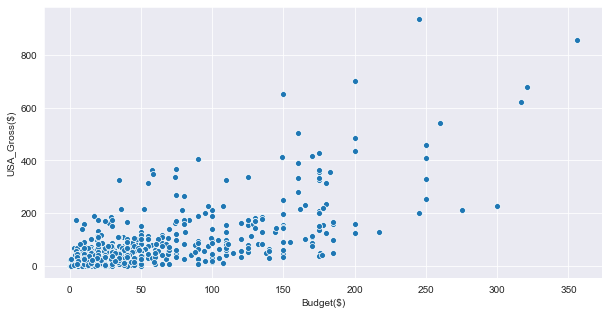

In [11]:
plt.figure(figsize = [10,5])
sns.scatterplot(data = df_movie_revenue, x = "Budget($)", y = "USA_Gross($)")

In [12]:
#Add categorial columns for the seasons
df_months = pd.DataFrame({"Released_Month" : list(range(1,13)), "Season" : [1,1,2,2,2,3,3,3,4,4,4,1], "Season_" : [1,1,2,2,2,2,2,2,1,1,1,1]})
df_season_revenue = pd.merge(df_movie_revenue, df_months, on = "Released_Month")
df_season_revenue

,Title_ID,Release_Year,Released_Month,Title,Genre,Production,USA_Gross($),Worldwide_Gross($),Budget($),Profit_US(%),Profit_W(%),Season,Season_
0,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",Universal Pictures,652.27,1670.40,150.00,3.35,10.14,3,2
1,tt0451279,2017,6.0,Wonder Woman,"Action,Adventure,Fantasy",Warner Bros. Pictures,412.56,821.85,149.00,1.77,4.52,3,2
2,tt1124037,2016,6.0,Free State of Jones,"Action,Biography,Drama",STX Entertainment,20.81,25.04,50.00,-0.58,-0.50,3,2
3,tt1489889,2016,6.0,Central Intelligence,"Action,Comedy,Crime",Warner Bros. Pictures,127.44,216.97,50.00,1.55,3.34,3,2
4,tt1628841,2016,6.0,Independence Day: Resurgence,"Action,Adventure,Sci-Fi",20th Century Fox,103.14,389.68,165.00,-0.37,1.36,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,tt7547410,2019,8.0,Dora and the Lost City of Gold,"Adventure,Family",Paramount Pictures,60.48,116.55,49.00,0.23,1.38,3,2
767,tt7668870,2018,8.0,Searching,"Drama,Mystery,Thriller",Screen Gems,26.02,75.46,0.88,28.57,84.75,3,2
768,tt7798634,2019,8.0,Ready or Not,"Comedy,Horror,Mystery",Fox Searchlight Pictures,28.71,57.15,6.00,3.78,8.52,3,2
769,tt8186318,2019,8.0,Overcomer,"Drama,Sport",Affirm Films,34.70,35.71,5.00,5.94,6.14,3,2


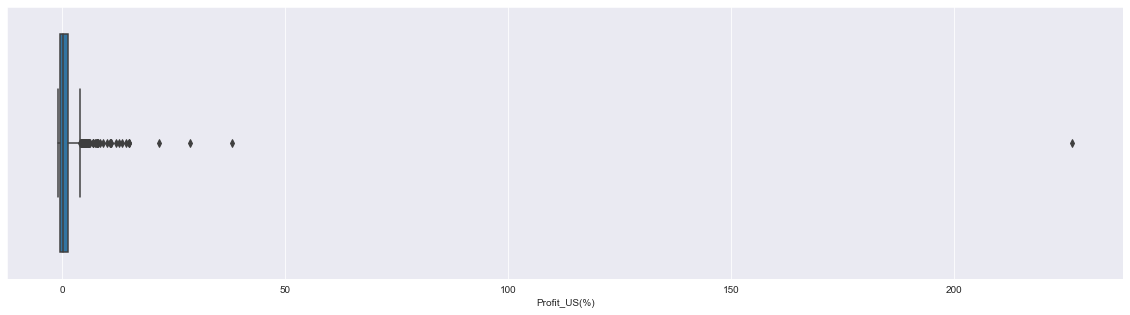

In [13]:
#Check the distribution of the profit column
plt.figure(figsize = [20,5])
sns.boxplot(df_season_revenue["Profit_US(%)"])

In [14]:
df_season_revenue["Profit_US(%)"].describe()

count    771.000000
mean       1.206615
std        8.641546
min       -1.000000
25%       -0.550000
50%        0.060000
75%        1.285000
max      226.600000
Name: Profit_US(%), dtype: float64

In [15]:
#The above boxplot and table are showing 4 outliers above 15/20%
#Remove the outliers profit > 15%
df_season_outliers = df_season_revenue[df_season_revenue["Profit_US(%)"] > 15]
df_season_outliers

,Title_ID,Release_Year,Released_Month,Title,Genre,Production,USA_Gross($),Worldwide_Gross($),Budget($),Profit_US(%),Profit_W(%),Season,Season_
171,tt5052448,2017,2.0,Get Out,"Horror,Mystery,Thriller",Universal Pictures,176.04,255.41,4.50,38.12,55.76,1,1
260,tt2309260,2015,7.0,The Gallows,"Horror,Mystery,Thriller",New Line Cinema,22.76,42.96,0.10,226.60,428.60,3,2
732,tt3832914,2015,8.0,War Room,Drama,Sony Pictures,67.79,73.26,3.00,21.60,23.42,3,2
767,tt7668870,2018,8.0,Searching,"Drama,Mystery,Thriller",Screen Gems,26.02,75.46,0.88,28.57,84.75,3,2


In [16]:
df_season_revenue = df_season_revenue[df_season_revenue["Profit_US(%)"] <= 15]
df_season_revenue

,Title_ID,Release_Year,Released_Month,Title,Genre,Production,USA_Gross($),Worldwide_Gross($),Budget($),Profit_US(%),Profit_W(%),Season,Season_
0,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",Universal Pictures,652.27,1670.40,150.0,3.35,10.14,3,2
1,tt0451279,2017,6.0,Wonder Woman,"Action,Adventure,Fantasy",Warner Bros. Pictures,412.56,821.85,149.0,1.77,4.52,3,2
2,tt1124037,2016,6.0,Free State of Jones,"Action,Biography,Drama",STX Entertainment,20.81,25.04,50.0,-0.58,-0.50,3,2
3,tt1489889,2016,6.0,Central Intelligence,"Action,Comedy,Crime",Warner Bros. Pictures,127.44,216.97,50.0,1.55,3.34,3,2
4,tt1628841,2016,6.0,Independence Day: Resurgence,"Action,Adventure,Sci-Fi",20th Century Fox,103.14,389.68,165.0,-0.37,1.36,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,tt7365604,2018,8.0,Dog Days,"Comedy,Drama,Romance",LD Entertainment,6.81,6.82,10.0,-0.32,-0.32,3,2
766,tt7547410,2019,8.0,Dora and the Lost City of Gold,"Adventure,Family",Paramount Pictures,60.48,116.55,49.0,0.23,1.38,3,2
768,tt7798634,2019,8.0,Ready or Not,"Comedy,Horror,Mystery",Fox Searchlight Pictures,28.71,57.15,6.0,3.78,8.52,3,2
769,tt8186318,2019,8.0,Overcomer,"Drama,Sport",Affirm Films,34.70,35.71,5.0,5.94,6.14,3,2


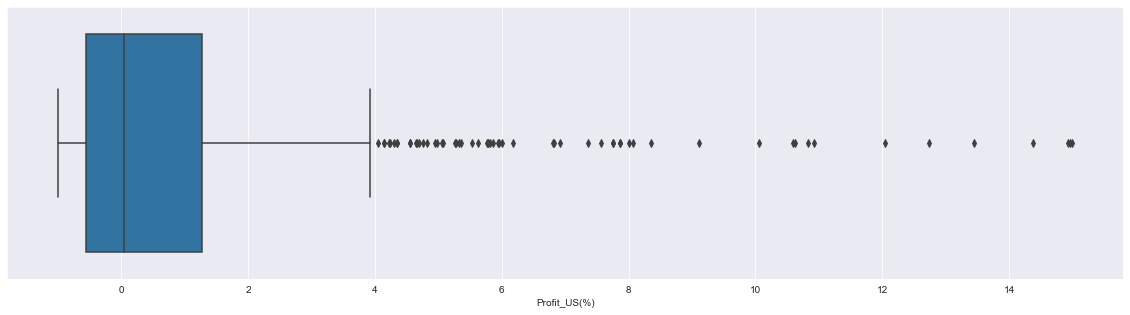

In [17]:
plt.figure(figsize = [20,5])
sns.boxplot(df_season_revenue["Profit_US(%)"])

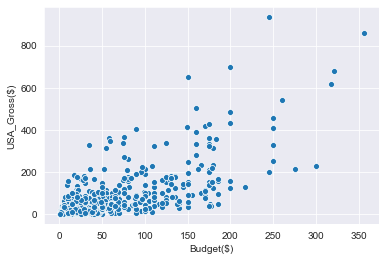

In [18]:
sns.scatterplot(data = df_season_revenue, x = "Budget($)", y = "USA_Gross($)")

In [19]:
#Create a subset for winter movies
df_winter = df_season_revenue[(df_season_revenue["Season"] == 1)]
df_winter["Profit_US(%)"].describe()

count    193.000000
mean       0.697306
std        1.944261
min       -1.000000
25%       -0.560000
50%        0.130000
75%        1.290000
max       14.370000
Name: Profit_US(%), dtype: float64

In [20]:
#Create a subset for summer movies which will be tested against winter movies
df_summer = df_season_revenue[(df_season_revenue["Season"] == 3)]
df_summer["Profit_US(%)"].describe()

count    188.000000
mean       1.043511
std        2.392632
min       -1.000000
25%       -0.427500
50%        0.310000
75%        1.687500
max       15.000000
Name: Profit_US(%), dtype: float64

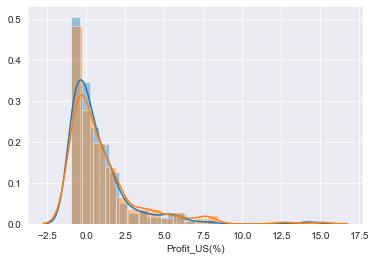

In [21]:
#Check distribution
sns.distplot(df_winter["Profit_US(%)"])
sns.distplot(df_summer["Profit_US(%)"])

#### For the above subsets, perform random sampling then compare sample variances and check for normality.

H0: sample comes from a normal distribution

HA: sample does not from a normal distribution

In [22]:
#Below functions perform random sampling and calculate for sample variance
def get_sample_mean(sample):
    return sum(sample) / len(sample)
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)  
    return sample
def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist
def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)

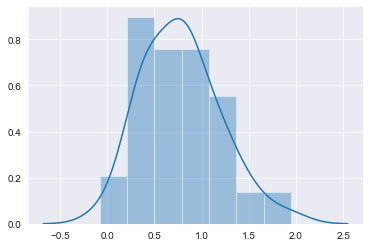

NormaltestResult(statistic=3.115900752627145, pvalue=0.21056721275771043)

In [23]:
#Perfom random sampling and normality test on winter movies
winter_sample = create_sample_distribution(df_winter["Profit_US(%)"], dist_size=50, n=30)
sns.distplot(winter_sample)
plt.show()
stats.normaltest(winter_sample)

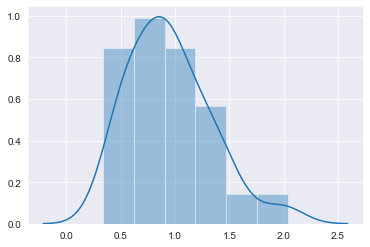

NormaltestResult(statistic=6.455888785867291, pvalue=0.03963889709524032)

In [24]:
#Perfom random sampling and normality test on summer movies
summer_sample = create_sample_distribution(df_summer["Profit_US(%)"], dist_size=50, n=30)
sns.distplot(summer_sample)
plt.show()
stats.normaltest(summer_sample)

In [25]:
winter_variance = sample_variance(winter_sample)
winter_mean = np.mean(winter_sample)
print("winter sample mean is", winter_mean)
print("winter sample variance is", winter_variance)

winter sample mean is 0.77862
winter sample variance is 0.1696900000453515


In [26]:
summer_variance = sample_variance(summer_sample)
summer_mean = np.mean(summer_sample)
print("summer sample mean is", summer_mean)
print("summer sample variance is", summer_variance)

summer sample mean is 0.9493466666666666
summer sample variance is 0.14338492045351475


In [27]:
winter_mean - summer_mean

-0.17072666666666658

 - p-values for the above normality tests are greater than the alpha = 0.05, H0 cannot be rejected then

 - winter and summer movie samples have similar variance

#### Perform one-tailed and two-tailed t-tests (alpha = 0.05)

H0: The mean profit difference between winter and summer movies is equal to zero (winter - summer = 0)

HA1: The mean profit difference between winter and summer movies is not equal to zero (winter - summer != 0)

HA2: The mean profit difference between winter and summer movies is greater than zero (winter - summer > 0)

In [28]:
alpha = 0.05
df = len(winter_sample) + len(summer_sample) - 2 #degrees of freedom
t_stat, p_value = stats.ttest_ind(winter_sample, summer_sample)
#t_crit = stats.t.ppf(1 - alpha, df) #same for all null and alternative hypotheses

In [29]:
#HA1: The mean profit difference between winter and summer movies is not equal to zero (winter - summer != 0)

print("t-statistic is ", t_stat)
#print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", p_value)

print("\n")
# if t_stat > t_crit:
#     print("t-statistic > t-critical value: there is a statistically significant difference between the 2 samples")
# else:
#     print("t-statistic < t-critical value: there is no statistically significant difference between the 2 samples")
    
if p_value < alpha/2:
    print("p-value < alpha/2: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha/2: we do not the null hypothesis at 5% significance level in support of the alternative")

t-statistic is  -2.1575567302201972
p-value is  0.03340660821500875


p-value > alpha/2: we do not the null hypothesis at 5% significance level in support of the alternative


In [30]:
#HA2: The mean profit difference between winter and summer movies is greater than zero (winter - summer > 0)

print("t-statistic is ", t_stat)
#print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", p_value)
print("\n")
if p_value < alpha:
    print("p-value < alpha: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha: we do not the null hypothesis at 5% significance level in support of the alternative")

t-statistic is  -2.1575567302201972
p-value is  0.03340660821500875


p-value < alpha: we reject the null hypothesis at 5% significance level in support of the alternative


### Are comedy movies more profitable than dramas?

Test is focused on last 5 years English movies released in the US taken from IMDB.  Profitability will be measured using the budget (converted into USD) and gross worldwide revenue (both in millions) scraped from each of the movie IMDB webpages. t-test will be performed on the mean profits of comedy and drama movies.

#### Perform EDA on  the data taken from IMDB.

Cleaned data *df_movie_revenue* will be used as a starting point.

In [31]:
df_genre_revenue = df_movie_revenue.copy()
df_genre_revenue

,Title_ID,Release_Year,Released_Month,Title,Genre,Production,USA_Gross($),Worldwide_Gross($),Budget($),Profit_US(%),Profit_W(%)
4,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",Universal Pictures,652.27,1670.40,150.0,3.35,10.14
6,tt0385887,2019,11.0,Motherless Brooklyn,"Crime,Drama",Warner Bros. Pictures,7.33,7.48,26.0,-0.72,-0.71
8,tt0437086,2019,2.0,Alita: Battle Angel,"Action,Adventure,Sci-Fi",20th Century Fox,85.71,404.85,170.0,-0.50,1.38
9,tt0448115,2019,4.0,Shazam!,"Action,Adventure,Comedy",New Line Cinema,140.37,364.57,100.0,0.40,2.65
10,tt0451279,2017,6.0,Wonder Woman,"Action,Adventure,Fantasy",Warner Bros. Pictures,412.56,821.85,149.0,1.77,4.52
...,...,...,...,...,...,...,...,...,...,...,...
1968,tt8385474,2019,5.0,A Dog's Journey,"Comedy,Drama,Family",Universal Pictures,22.55,71.75,16.0,0.41,3.48
1979,tt8663516,2019,6.0,Child's Play,Horror,NaN,29.21,44.90,10.0,1.92,3.49
1988,tt8772262,2019,7.0,Midsommar,"Drama,Horror,Mystery",A24,27.43,41.12,10.0,1.74,3.11
1997,tt9024106,2019,3.0,Unplanned,"Biography,Drama",Pure Flix,19.01,19.32,6.0,2.17,2.22


In [32]:
#Check top genres excluding those movies under multiple genres
q = """SELECT * FROM df_genre_revenue WHERE Genre NOT LIKE "%,%";"""
df_genre_ = pysqldf(q)
display(df_genre_.info())
df_genre_[["Genre", "Profit_W(%)"]].groupby("Genre").mean().sort_values("Profit_W(%)", ascending = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 11 columns):
Title_ID              54 non-null object
Release_Year          54 non-null int64
Released_Month        54 non-null float64
Title                 54 non-null object
Genre                 54 non-null object
Production            52 non-null object
USA_Gross($)          54 non-null float64
Worldwide_Gross($)    54 non-null float64
Budget($)             54 non-null float64
Profit_US(%)          54 non-null float64
Profit_W(%)           54 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 4.8+ KB


None

,Profit_W(%)
Genre,
Horror,5.954000
Drama,2.924545
Comedy,1.906538
Musical,0.270000


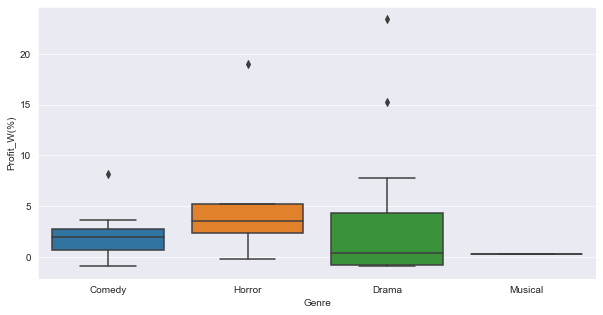

In [33]:
plt.figure(figsize = [10,5])
sns.boxplot(data = df_genre_, x = df_genre_["Genre"], y = df_genre_["Profit_W(%)"])

In [34]:
#Check drama stats
df_genre_.query("Genre == 'Horror'")["Profit_W(%)"].describe()

count     5.00000
mean      5.95400
std       7.56309
min      -0.24000
25%       2.30000
50%       3.49000
75%       5.21000
max      19.01000
Name: Profit_W(%), dtype: float64

In [35]:
#Check comedy stats
df_genre_.query("Genre == 'Comedy'")["Profit_W(%)"].describe()

count    26.000000
mean      1.906538
std       1.890460
min      -0.930000
25%       0.697500
50%       1.950000
75%       2.755000
max       8.200000
Name: Profit_W(%), dtype: float64

In [36]:
#Check horror stats
df_genre_.query("Genre == 'Drama'")["Profit_W(%)"].describe()

count    22.000000
mean      2.924545
std       6.007583
min      -0.950000
25%      -0.772500
50%       0.345000
75%       4.342500
max      23.420000
Name: Profit_W(%), dtype: float64

In [37]:
#Create subsets for horror movies.  All movies under genre horror only.
df_genre_comedy = df_genre_.query("Genre == 'Comedy'")

In [38]:
#Create subsets for comedy movies.  All movies under genre comedy only.
df_genre_drama = df_genre_.query("Genre == 'Drama'")

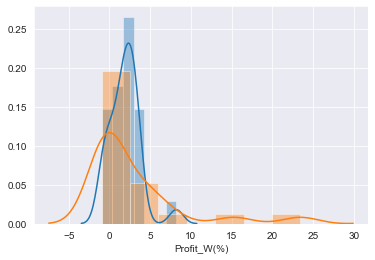

In [39]:
#Check distribution
sns.distplot(df_genre_comedy["Profit_W(%)"])
sns.distplot(df_genre_drama["Profit_W(%)"])

#### For the above subsets, perform random sampling then compare sample variances and check for normality.

H0: sample comes from a normal distribution

HA: sample does not from a normal distribution

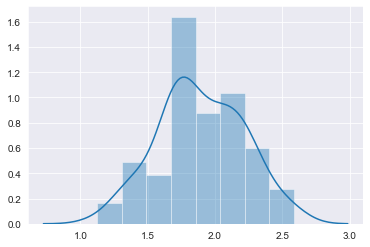

NormaltestResult(statistic=0.8612976936092115, pvalue=0.6500871508790992)

In [40]:
#Perfom random sampling and normality test on comedy movies
comedy_sample = create_sample_distribution(df_genre_comedy["Profit_W(%)"], dist_size=100, n=30)
sns.distplot(comedy_sample)
plt.show()
stats.normaltest(comedy_sample)

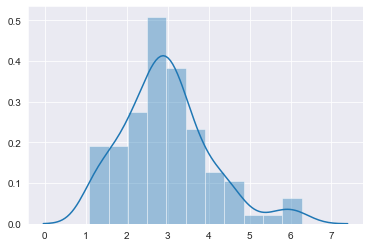

NormaltestResult(statistic=10.780173538053758, pvalue=0.004561577514920847)

In [41]:
#Perfom random sampling and normality test on comedy movies
drama_sample = create_sample_distribution(df_genre_drama["Profit_W(%)"], dist_size=100, n=30)
sns.distplot(drama_sample)
plt.show()
stats.normaltest(drama_sample)

In [42]:
comedy_variance = sample_variance(comedy_sample)
comedy_mean = np.mean(comedy_sample)
print("comedy sample mean is", comedy_mean)
print("comedy sample variance is", comedy_variance)

comedy sample mean is 1.8942233333333336
comedy sample variance is 0.09959088003367007


In [43]:
drama_variance = sample_variance(drama_sample)
drama_mean = np.mean(drama_sample)
print("drama sample mean is", drama_mean)
print("drama sample variance is", drama_variance)

drama sample mean is 2.95773
drama sample variance is 1.1523151642985414


In [44]:
comedy_mean - drama_mean

-1.0635066666666666

 - p-values for the above normality tests are greater than the alpha = 0.05, H0 cannot be rejected then

 - comedy and drama movie sample variances are not very similar

#### Perform one-tailed and two-tailed Welch's t-tests (alpha = 0.05)

H0: The mean profit difference between drama and comedy movies is equal to zero (comedy - drama = 0)

HA1: The mean profit difference between drama and comedy movies is not equal to zero (comedy - drama != 0)

HA2: The mean profit difference between drama and comedy movies is greater than zero (comedy - drama > 0)

In [45]:
alpha = 0.05
df = len(drama_sample) + len(comedy_sample) - 2 #degrees of freedom
t_stat, p_value = stats.ttest_ind(comedy_sample , drama_sample, equal_var=False) #two-tailed p-value
#t_crit = stats.t.ppf(1 - alpha, df) #same for all null and alternative hypotheses

In [46]:
#HA1: The mean profit difference between drama and comedy movies is not equal to zero (drama - comedy != 0)

print("t-statistic is ", t_stat)
#print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", p_value)
print("\n")
if p_value < alpha/2:
    print("p-value < alpha/2: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha/2: we do not the null hypothesis at 5% significance level in support of the alternative")

t-statistic is  -9.505048747493438
p-value is  3.4352160737468946e-16


p-value < alpha/2: we reject the null hypothesis at 5% significance level in support of the alternative


In [47]:
#HA2: The mean profit difference between drama and comedy movies is greater than zero (drama - comedy > 0)

print("t-statistic is ", t_stat)
#print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", p_value)
print("\n")
if p_value < alpha:
    print("p-value < alpha: we reject the null hypothesis at 5% significance level in support of the alternative")
else:
    print("p-value > alpha: we do not the null hypothesis at 5% significance level in support of the alternative")

t-statistic is  -9.505048747493438
p-value is  3.4352160737468946e-16


p-value < alpha: we reject the null hypothesis at 5% significance level in support of the alternative
